In [1]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from itertools import product
import torch
import numpy as np
from matplotlib.patches import FancyArrowPatch
import mlflow
import warnings
warnings.filterwarnings("ignore")

from even_flow.models.neuralode import TimeEmbeddingMLPNeuralODEModel
from even_flow.moons.dataset import MoonsDataset
from even_flow.moons.jobs import MoonsTimeEmbeddinngMLPNeuralODEJob
from even_flow.utils import flatten_dict

# Params

In [2]:
experiment_name = 'Moons Neural ODE'
mlflow.set_experiment(experiment_name)
experiment = mlflow.get_experiment_by_name(experiment_name)
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
runs_df

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test.eval_end,metrics.train.loss,metrics.exec_duration,metrics.test.eval_start,...,params.model.num_sanity_val_steps,params.datamodule.train_samples,params.datamodule.noise,params.model.vector_field.activations,params.datamodule.val_samples,tags.mlflow.runName,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.source.git.commit
0,e0543087fa044feba1082a58f0532551,429125219810725253,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-11-30 07:44:50.892000+00:00,2025-11-30 07:44:59.913000+00:00,1.764489e+09,2.472665,9.012347,1.764489e+09,...,5,10000,0.05,"[""relu"", ""relu"", ""relu"", ""relu""]",1000,time-embedding-mlp-neural-ode-899,lucasbanunes,run_all.py,LOCAL,0ba17eae9640c8c43d72179845d143547165878c
1,2a0047dc8e584faea9146fd197136c00,429125219810725253,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-11-30 07:44:42.453000+00:00,2025-11-30 07:44:50.889000+00:00,1.764489e+09,2.432193,8.427122,1.764489e+09,...,5,10000,0.05,"[""relu"", ""relu"", ""relu""]",1000,time-embedding-mlp-neural-ode-898,lucasbanunes,run_all.py,LOCAL,0ba17eae9640c8c43d72179845d143547165878c
2,3b962f0e98fe4b75b737a2c5d206ccfc,429125219810725253,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-11-30 07:44:32.462000+00:00,2025-11-30 07:44:42.450000+00:00,1.764489e+09,2.432042,9.978887,1.764489e+09,...,5,10000,0.05,"[""relu"", ""relu""]",1000,time-embedding-mlp-neural-ode-897,lucasbanunes,run_all.py,LOCAL,0ba17eae9640c8c43d72179845d143547165878c
3,d677dad231a24473b2a9967e6152c863,429125219810725253,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-11-30 07:43:51.126000+00:00,2025-11-30 07:44:32.460000+00:00,1.764489e+09,2.494675,41.324815,1.764489e+09,...,5,10000,0.05,"[""relu"", ""relu"", ""relu"", ""relu""]",1000,time-embedding-mlp-neural-ode-896,lucasbanunes,run_all.py,LOCAL,0ba17eae9640c8c43d72179845d143547165878c
4,00931bfa6c964830b0ffa15c2e27b9cf,429125219810725253,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-11-30 07:43:14.802000+00:00,2025-11-30 07:43:51.124000+00:00,1.764489e+09,2.494675,36.313361,1.764489e+09,...,5,10000,0.05,"[""relu"", ""relu"", ""relu""]",1000,time-embedding-mlp-neural-ode-895,lucasbanunes,run_all.py,LOCAL,0ba17eae9640c8c43d72179845d143547165878c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,c5bb17ed36f04be4b4ede19817600ac1,429125219810725253,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-11-30 03:01:24.796000+00:00,2025-11-30 03:01:59.976000+00:00,1.764472e+09,2.494675,35.176417,1.764472e+09,...,5,10000,0.05,"[""relu"", ""relu"", ""relu""]",1000,time-embedding-mlp-neural-ode-4,lucasbanunes,run_all.py,LOCAL,0ba17eae9640c8c43d72179845d143547165878c
896,4335c078484f40b4aff8ba8f8f3a4fd7,429125219810725253,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-11-30 03:01:02.367000+00:00,2025-11-30 03:01:24.794000+00:00,1.764472e+09,2.410357,22.422933,1.764472e+09,...,5,10000,0.05,"[""relu"", ""relu""]",1000,time-embedding-mlp-neural-ode-3,lucasbanunes,run_all.py,LOCAL,0ba17eae9640c8c43d72179845d143547165878c
897,8f42a2c679e847d5b55c12c69c75ef7c,429125219810725253,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-11-30 03:00:56.095000+00:00,2025-11-30 03:01:02.365000+00:00,1.764472e+09,2.494675,6.266466,1.764472e+09,...,5,10000,0.05,"[""relu"", ""relu"", ""relu"", ""relu""]",1000,time-embedding-mlp-neural-ode-2,lucasbanunes,run_all.py,LOCAL,0ba17eae9640c8c43d72179845d143547165878c
898,879b84936c754b96a705fe98a542e360,429125219810725253,FINISHED,file:///home/lucasbanunes/workspaces/even-flow...,2025-11-30 03:00:48.914000+00:00,2025-11-30 03:00:56.092000+00:00,1.764472e+09,2.472748,7.172812,1.764472e+09,...,5,10000,0.05,"[""relu"", ""relu"", ""relu""]",1000,time-embedding-mlp-neural-ode-1,lucasbanunes,run_all.py,LOCAL,0ba17eae9640c8c43d72179845d143547165878c


In [3]:
for i, col in enumerate(runs_df.columns):
    print(f'{i} - {col}')

0 - run_id
1 - experiment_id
2 - status
3 - artifact_uri
4 - start_time
5 - end_time
6 - metrics.test.eval_end
7 - metrics.train.loss
8 - metrics.exec_duration
9 - metrics.test.eval_start
10 - metrics.fit_start
11 - metrics.test.nfe
12 - metrics.exec_end
13 - metrics.val.eval_start
14 - metrics.train_loss_step
15 - metrics.train.eval_start
16 - metrics.test.eval_duration
17 - metrics.val.nfe
18 - metrics.val.loss
19 - metrics.fit_duration
20 - metrics.val.eval_duration
21 - metrics.test.loss
22 - metrics.val_loss
23 - metrics.train_loss_epoch
24 - metrics.exec_start
25 - metrics.fit_end
26 - metrics.epoch
27 - metrics.val.eval_end
28 - metrics.train.nfe
29 - metrics.train.eval_duration
30 - metrics.train.eval_end
31 - params.model.vector_field.time_embed_dims
32 - params.model.learning_rate
33 - params.model.early_stopping..patience
34 - params.model.base_distribution
35 - params.model.vector_field.time_embed_freq
36 - params.model.checkpoint.save_top_k
37 - params.model.verbose
38 - p

# Statistical Analysis

## Relative tolerance X NFE

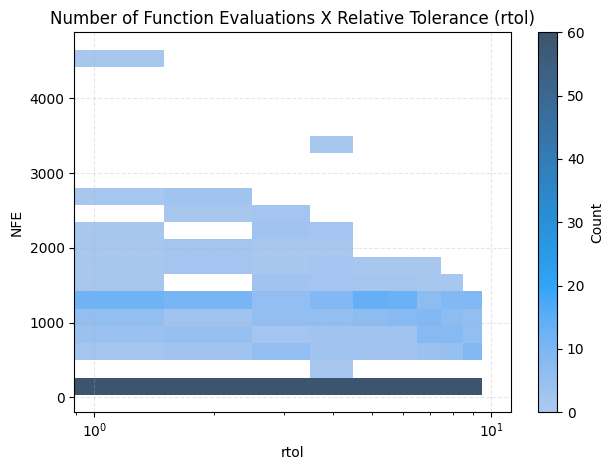

In [4]:
fig, ax = plt.subplots()
ax.grid(alpha=.3, linestyle='--')
sns.histplot(
    runs_df,
    x='params.model.rtol',
    y='metrics.test.nfe',
    ax=ax,
    cbar=True,
    cbar_kws={'label': 'Count'},
    bins=20
)
ax.set_title(
    'Number of Function Evaluations X Relative Tolerance (rtol)',
    fontsize='large'
)
ax.set_xlabel('rtol', fontsize='medium')
ax.set_ylabel('NFE', fontsize='medium')
ax.set_xscale('log')
fig.tight_layout()

## Absolute Tolerance x NFE

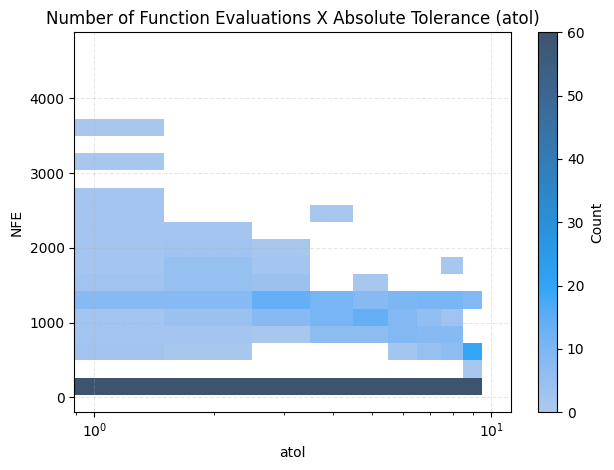

In [5]:
fig, ax = plt.subplots()
ax.grid(alpha=.3, linestyle='--')
sns.histplot(
    runs_df,
    x='params.model.atol',
    y='metrics.test.nfe',
    ax=ax,
    cbar=True,
    cbar_kws={'label': 'Count'},
    bins=20
)
ax.set_title(
    'Number of Function Evaluations X Absolute Tolerance (atol)',
    fontsize='large'
)
ax.set_xlabel('atol', fontsize='medium')
ax.set_ylabel('NFE', fontsize='medium')
ax.set_xscale('log')
fig.tight_layout()

## Solver x NFE

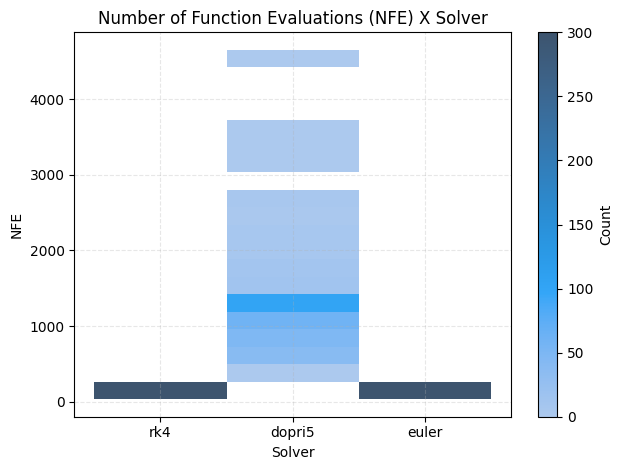

In [6]:
fig, ax = plt.subplots()
ax.grid(alpha=.3, linestyle='--')
sns.histplot(
    runs_df,
    x='params.model.solver',
    y='metrics.test.nfe',
    ax=ax,
    cbar=True,
    cbar_kws={'label': 'Count'},
    bins=20
)
ax.set_title(
    'Number of Function Evaluations (NFE) X Solver',
    fontsize='large'
)
ax.set_xlabel('Solver', fontsize='medium')
ax.set_ylabel('NFE', fontsize='medium')
fig.tight_layout()

## Fit duration

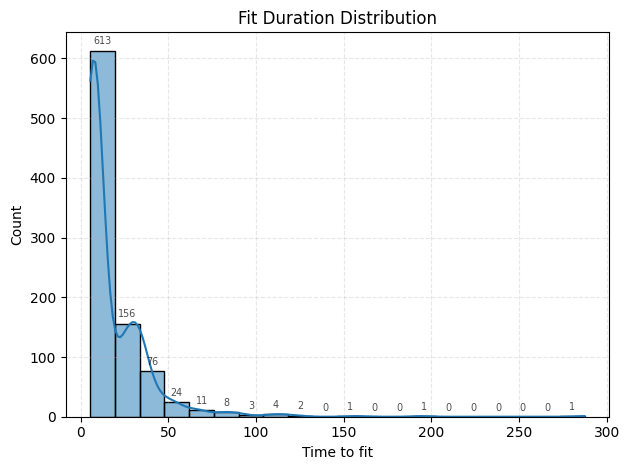

In [7]:
fig, ax = plt.subplots()
ax.grid(alpha=.3, linestyle='--')
sns.histplot(
    runs_df,
    x='metrics.fit_duration',
    ax=ax,
    cbar=True,
    cbar_kws={'label': 'Count'},
    bins=20,
    kde=True,
)
plt.bar_label(ax.containers[0], fmt='%.0f', label_type='edge', padding=3,
              fontsize='x-small', alpha=0.7) 
ax.set_title(
    'Fit Duration Distribution',
    fontsize='large'
)
ax.set_xlabel('Time to fit', fontsize='medium')
fig.tight_layout()

## Solver x Test Loss

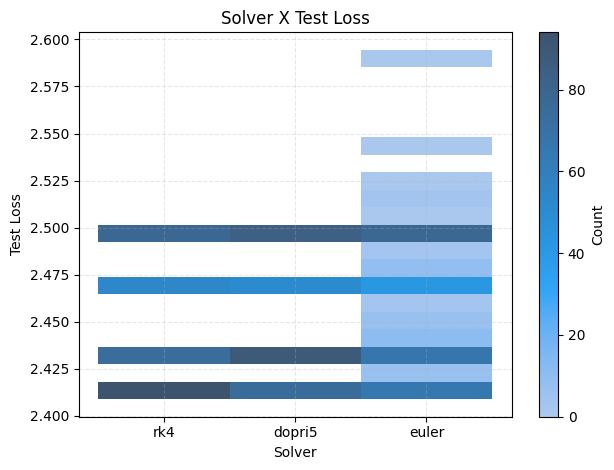

In [8]:
fig, ax = plt.subplots()
ax.grid(alpha=.3, linestyle='--')
sns.histplot(
    runs_df,
    x='params.model.solver',
    y='metrics.test.loss',
    ax=ax,
    cbar=True,
    cbar_kws={'label': 'Count'},
    bins=20
)
ax.set_title(
    'Solver X Test Loss',
    fontsize='large'
)
ax.set_xlabel('Solver', fontsize='medium')
ax.set_ylabel('Test Loss', fontsize='medium')
fig.tight_layout()

# Individual analysis

In [9]:
min_test_loss_idx = runs_df['metrics.test.loss'].idxmin()
min_test_loss_run = runs_df.loc[min_test_loss_idx]
min_test_loss_job = MoonsTimeEmbeddinngMLPNeuralODEJob.from_mlflow_run_id(min_test_loss_run['run_id'])
min_test_loss_job

MoonsTimeEmbeddinngMLPNeuralODEJob(id_='43a6fca5597147e4a0b9d049af3ba4a3', name='time-embedding-mlp-neural-ode-392', model=TimeEmbeddingMLPNeuralODEModel(id_=None, name=None, prefix='', accelerator='cpu', profiler='simple', max_epochs=100, verbose=False, num_sanity_val_steps=5, checkpoint=ModelCheckpointConfig(id_=None, name=None, prefix='', dirpath=None, monitor='val_loss', mode='min', save_top_k=3, filename='checkpoint-{epoch:02d}-{val_loss:.2f}'), early_stopping=EarlyStoppingConfig(id_=None, name=None, prefix='', monitor='val_loss', patience=3, min_delta=0.001, mode='min'), vector_field=TimeEmbeddingMLPConfig(id_=None, name=None, prefix='', input_dims=2, time_embed_dims=2, time_embed_freq=10.0, neurons_per_layer=[16, 16, 16, 2], activations=['relu', 'relu', 'relu', 'relu']), base_distribution='standard_normal', integration_times=[0.0, 1.0], learning_rate=0.001, adjoint=True, solver='dopri5', atol=0.00021544346900318823, rtol=5.994842503189409e-05, input_shape=(2,)), datamodule=<even

Are the transformed samples equal to the base samples? False


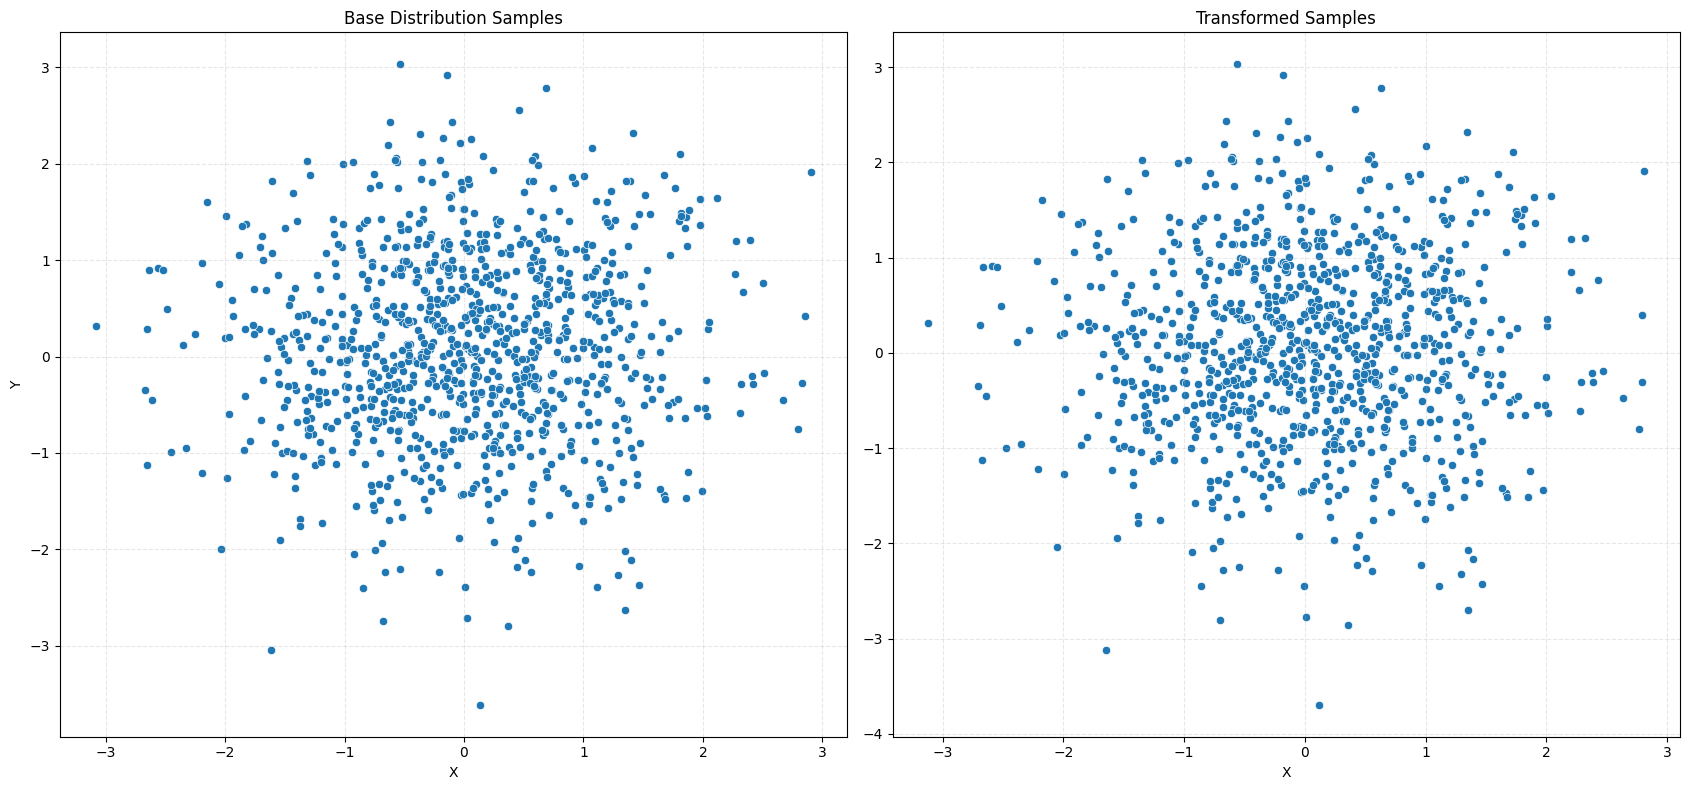

In [22]:
transformed_samples, base_samples, fig, axes = min_test_loss_job.plot_comparison(1000)
is_equal = np.allclose(transformed_samples, base_samples)
print(f'Are the transformed samples equal to the base samples? {is_equal}')
fig.tight_layout()

Text(0, 0.5, 'Y')

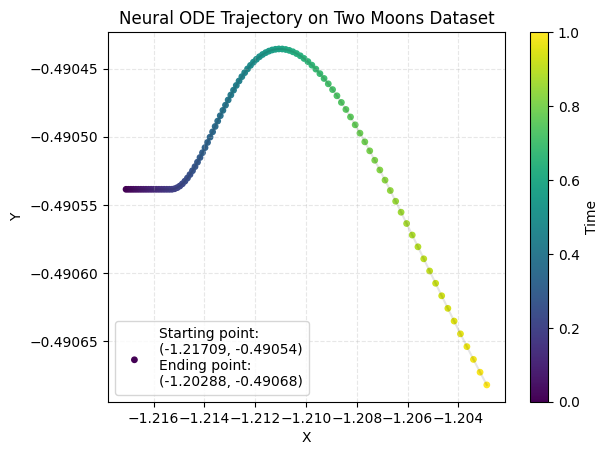

In [26]:
time = np.linspace(0., 1., num=100).astype(np.float32)
trajectory = min_test_loss_job.model.trajectory(
    torch.from_numpy(base_samples[1].reshape(1, -1)),
    integration_times=torch.from_numpy(time)
)
trajectory = trajectory.detach().cpu().numpy().squeeze()
fig, ax = plt.subplots()
ax.grid(alpha=.3, linestyle='--')
text = (
    'Starting point:\n'
    f'({trajectory[0, 0]:.5f}, {trajectory[0, 1]:.5f})\n'
    'Ending point:\n'
    f'({trajectory[-1, 0]:.5f}, {trajectory[-1, 1]:.5f})'
)
ax.plot(trajectory[:, 0], trajectory[:, 1],
        color='k', alpha=0.1)
scatter = ax.scatter(trajectory[:, 0], trajectory[:, 1],
           s=np.full(trajectory.shape[0], 15),
           c=time,
           cmap='viridis',
           label=text,
           alpha=1)
plt.colorbar(scatter, ax=ax, label='Time')
ax.legend()
ax.set_title(
    'Neural ODE Trajectory on Two Moons Dataset',
    fontsize='large'
)
ax.set_xlabel('X', fontsize='medium')
ax.set_ylabel('Y', fontsize='medium')

In [15]:
metrics = ['epoch', 'train_loss_epoch', 'val_loss']
metric_history = min_test_loss_job.get_metric_history(metrics)
metric_history = metric_history.dropna(axis=0)
metric_history

,epoch,train_loss_epoch,val_loss
312,0.0,2.469787,2.406537
625,1.0,2.410498,2.404796
938,2.0,2.409876,2.404587
1251,3.0,2.409773,2.404560
1564,4.0,2.409765,2.404557


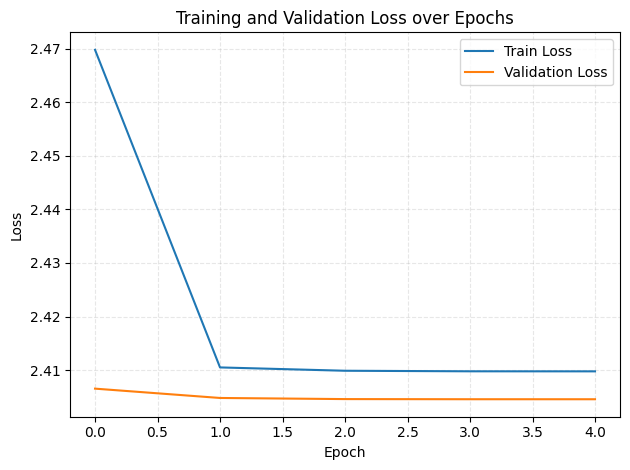

In [19]:
fig, ax = plt.subplots()
ax.grid(alpha=.3, linestyle='--')
ax.plot(
    metric_history['epoch'],
    metric_history['train_loss_epoch'],
    label='Train Loss'
)
ax.plot(
    metric_history['epoch'],
    metric_history['val_loss'],
    label='Validation Loss'
)
ax.set_title(
    'Training and Validation Loss over Epochs',
    fontsize='large'
)
ax.set_xlabel('Epoch', fontsize='medium')
ax.set_ylabel('Loss', fontsize='medium')
ax.legend()
fig.tight_layout()